# Work structure
Quero discutir duas questões fundamentais:

1. O que é justiça social e como ela passa a ser justiça territorial (spatial justice)?
2. Quais os pricipais principios de justiça?


1. Como medir justiça espacial por meio da distância?
2. Como mensurar a dificuldade de se chegar a uma oportunidade além das condições físicas de mobilidade (distância) e de acesso? (em outras palavras, o que caracteriza a diferença de acesso para diferentes grupos socio-economicos)

Pensar nessas questões a partir de uma componente espacial de justiça (Fainstein, 2014) usando a distância como unidade de medida.


Em seguida quero compreender a impedância como um fator que pode gerar diferentes interpretações do espaço urbano e usar essa métrica num lugar conhecido (Aveiro-Ílhavo). Depois de compreender que fatores socio-econômicos podem influenciar o "ease of access" às oportunidades, quero aplicar uma fórmula na impedância (distância) para calcular um indicador de "acessibilidade social"


Justice is 
Ease of access
the way access is measured is not satisfatory (why)
qualidade não é um fator relevante para essa análise.

---

### To Do:

- [ ] Discutir (1)"medição de justiça espacial" de forma mais direta para rawls e utilitarismo, com base na literatura
- [ ] Identificar na literatura mais fatores socio-economicos que podem influenciar a impedância (2)
- [ ] Criar funções de impedância
- [X] Criar modelo para Aveiro/ílhavo e aplicar funções de impedância conhecidas [DONE]
- [ ] Aplicar funções de impedância social para aveiro/ílhavo

## (1) Perspectiva de medição de justiça ou de bem-estar 

### Abordagem de capacidade (Sen, Nussbaum)
Justiça é oferecer o mínimo de acesso às oportunidades (capacidades) que permitem ao indivíduo ter escolhas para viver a vida como deseja (functionings) e ter bem estar (de acordo com suas preferências(Pref))

   * Existe uma discussão na literatura científica sobre a métrica de justiça baseada em oportunidades (capacidades) ou em resultados (functionings)
   * A abordagem de capacidade não é um princípio de justiça completo (Nussbaum 2006: 71). Como mensurar a justiça depois que todos tiverem acesso básico às oportunidades?
   * São usados indicadores composósitos de bem-estar ou de justiça, como o IDH que agrega diferentes grupos. Entretanto, a abordagem mais adequada sugere o maior nível de desagregamento possível, ao nível do indivíduo(Pref). Marc Fleurbacy sugere uma medida individualizada baseada em preferências para encontrar a **renda equivalente**: quanto de renda a pessoa estaria disposta a abrir mão para ter mais saúde ou mais tempo livre?
   * Considerando o modelo gravitacional, acredito que a melhor abordagem é criar uma função baseada na impedância cumulativa considerando os 7 tópicos essenciais (públicos) que Nussbaum elicita.

##### Capacidade vs Utilitarismo
* Uma alternativa para as visões normativas que focam em exercícios hipotéticos de avaliação. Basicamente, o que é sugerido pelo utilitarismo para medição do bem estar (ou da justiça), que é focado exclusivamente na utilidade (Sen 1999: 59,62), ou seja estados mentais e sentimentos de "felicidade", ou "contentamento"
* Também há problema para as coisas que ficam de fora desse tipo de avaliação. A informação de não utilidade excluída também deveria ser considerada, como as capacidades físicas, ou condições de saúde de nascença. 
* Princípios morais e sociais, também não são considerados pelo utilitarismo, como salários iguais para as mesmas funções. 
* Para o utilitarismo, homens devem ganhar mais enquanto as mulheres estiverem satisfeitas com o que ganham e a utilidade do sistema seja maximizada. 


##### Capacidade vs Rawls
“the primary goods approach seems to take little note of the diversity of human beings. … If people were basically very similar, then an index of primary goods might be quite a good way of judging advantage. But, in fact, people seem to have very different needs varying with health, longevity, climatic conditions, location, work conditions, temperament, and even body size.    …    So what is being involved is not merely ignoring a few hard cases, but overlooking very widespread and real differences” 
(Sen 1980: 215–216)

* Autores da abordagem de capacidade acreditam que o problema geral de medir a justiça a partir dos "bens primários" (rawls primary goods) é que eles não lidam de forma adequada com a diversidade humana, já que não foca em resultados mas sim nos meios (greatest equal liberty principle), e portanto deixa alguns grupos de fora do escopo da justiça.


### Teoria de Justiça "Rawlsiana" (Rawls, Fainstein)
Justiça é distribuir recursos e serviços desigualmente de forma a fornecer o melhor benefício possível para os menos favorecidos (Rawls, 1999). [Difference Principle]

Justiça também é fornecer igual acesso a recursos básicos, bens, renda e riqueza, oportunidades e **liberdades** (Rawls, 1971) [greatest equal liberty principle]



### Utilitarismo
Justiça é maximizar o nível de satisfação do sistema, ou seja, distriuir o recurso de tal forma que o valor total de satisfação do sistema seja o maior possível.

## (2) Distância e grupo social -> Impedância social

Quanto maior a disância e menor o grupo social, mais difícil é o acesso à oportunidade. O problema é:

* O quão mais difícil é para cada grupo, e por que?
* Quais são as características socio-econômicas de cada grupo que justificam a facilidade (ou dificuldade) de acesso? (ie. possui carro, tem acesso a parada de autocarro nas redondezas)
    * Necessidade de ter duas medidas: uma para as oportunidades (modelo gravitacional) e outra para a mobilidade (o tipo de facilidade que o indivíduo tem para acessar as facilidades
    * Comparar medidas com a média (para se adequar a uma norma). Inclusive SE eu for trabalhar com preferências individuais (ie. Mapa de classificação com os valores que mais se aproximam ou se distanciam da média)
    
    
#### Quais fatores socio-economicos auxiliam/prejudicam o acesso (ou o que sei até agora)



which justifies the construction of local indexes (Arellana et al., 2020)

individual socioeconomic factors and their perceptions on the conditions of the infrastructure and the built environment strongly impact the decision to travel by active modes (Larrañaga et al., 2016, Arellana et al., 2020).

People from higher social classes tends to commute with car:
the socioeconomic level, 82.4% of respondents belonged to strata 1 and 2, 16.2% to strata 3 and 4, and 1.4% to strata 5 and 6. This socioeconomic distribution suggests that most of the bicycle users in the city are low-income people.



---
### Impedance Experiments
Objective: Test different impedance functions 

Based on paper


Vale, D. S., Saraiva, M., & Pereira, M. (2016). Active accessibility: A review of operational measures of walking and cycling accessibility. Journal of Transport and Land Use. University of Minnesota. https://doi.org/10.5198/jtlu.2015.593

In [1]:
# List of Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
import geopandas as gpd
from pandana.loaders import osm
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_point_X_Y(points_dataframe):
    """ Returns a geodataframe with lat and long decomposed from 
    geometry on given dataframe
    Creteas two Series (lat and long) and alocate them on nodeX and nodeY """
    nodesX = []
    nodesY = []
    for e in points_dataframe[['geometry']].iterrows():
        nodesX.append(e[1].geometry.x)
        nodesY.append(e[1].geometry.y)
    points_dataframe['nodeX'] = nodesX
    points_dataframe['nodeY'] = nodesY
    return points_dataframe

def select_accessibility(regionName):
    accessibility_selection = pd.read_csv('data/accessibility/'+regionName+'/accessibilityMean.csv', dtype={'key_0':str})
    accessibility_selection['key_0'] = accessibility_selection['key_0'].apply(lambda x: str(x).zfill(11))
    accessibility_selection = clean_accessibility_df(accessibility_selection)
    return accessibility_selection

def clean_accessibility_df(access_df):
    access_df = access_df.rename(columns={'key_0':"BGRI",'1':'accessN1', '2':'accessN2', '3':'accessN3'})
    access_df = access_df.drop(columns=['Unnamed: 0'])
    return access_df

In [3]:
# Load Polygon data
portugal_polygon = gpd.read_file('../data/CONTINENTE/BGRI11_CONT.shp')

In [4]:
# Load Qualification Indexes
portugal_qi = pd.read_excel('../data/qualification_index/qi_portugal.xlsx', dtype={'BGRI11': str, 'IQ':float} )

In [5]:
# Load Schools Data
schools = gpd.read_file('../data/escolas_portugal_corrigido/gdf_escolas_publicas_1CEB.shx')
schools = schools.to_crs({'init':'epsg:4326'})

In [6]:
# Select Aveiro(0105) and Ílhavo(0110) cities From Continental Portugal
aveiro_ilhavo_polygon = portugal_polygon[(portugal_polygon['DTMN11']=='0105') | (portugal_polygon['DTMN11']=='0110')]

In [7]:
# Adjust projection to wgs-84 and get subsection centroids
aveiro_ilhavo_polygon = aveiro_ilhavo_polygon.to_crs({'init': 'epsg:4326'})
aveiro_ilhavo_polygon['temp'] = 1
aveiro_ilhavo_shape = aveiro_ilhavo_polygon.dissolve(by='temp')
aveiro_ilhavo_centroids = aveiro_ilhavo_polygon.centroid


In [8]:
# Get only the schools that are inside Aveiro_Ilhavo Region
aveiro_ilhavo_schools = gpd.sjoin(schools[['ESCOLA','CÓD. DGPGF','geometry']],aveiro_ilhavo_shape[['geometry']],how='inner', op='intersects')
aveiro_ilhavo_schools = get_point_X_Y(aveiro_ilhavo_schools)

In [9]:
# Get Polygon Bounds
bounds = aveiro_ilhavo_polygon.total_bounds
bbox = [bounds[1], bounds[0], bounds[3], bounds[2]]

In [10]:
# Create Pandana Network
network = osm.pdna_network_from_bbox(*bbox)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](40.52848367,-8.76608888,40.72755360,-8.52096487);>;);out;'}"
Downloaded 10,077.5KB from www.overpass-api.de in 2.00 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 2.18 seconds
Returning OSM data with 77,669 nodes and 10,986 ways...
Edge node pairs completed. Took 16.41 seconds
Returning processed graph with 13,836 nodes and 19,523 edges...
Completed OSM data download and Pandana node and edge table creation in 20.43 seconds


In [11]:
# Create POIS and precompute
maxDistance = 10000
maxItems = 5
network.set_pois('schools', maxDistance, maxItems, aveiro_ilhavo_schools['nodeX'],aveiro_ilhavo_schools['nodeY'])
network.precompute(maxDistance)

In [12]:
# Generate the accessibility
accessibility = network.nearest_pois(1000, 'schools', num_pois=3, imp_name='distance')

### Impedance class definition
Used to apply different impedance functions on the accessibily dataframe

According to Vale (Vale et al., 2016) 

" ... gravity-based measures explicitly assume attenuation toward travel. Three functions are often used: inverse power, negative exponential, and modified Gaussian"

Parameters were established by analyzing the changes in the rate of decline and the point at which the function approaches zero (Figure 3). Specifically, we established different values (0.50, 0.25, 0.125, 0.062, and 0.031) of the function at different distances from origins. Fifty meters from the origin was chosen for power functions due to the high elasticity of the function near the origin, whereas for exponential measures we used 200 m. The parameters for Gaussian measures were established by setting the distance at which the function would take the value 0.50. The thresholds used for cumulative measures were based on the quarter-mile (400 m) rule of thumb, extended by intervals of 200 m. Finally, the cumulative–Gaussian parameters were chosen with two different criteria. CuGa1 and CuGa2 assume a 200m indifference travel distance and differ by altering the parameter of the Gaussian part. CuGa3 and CuGa4 assume a 400m indifference travel distance and also differ by altering the Gaussian part of the function.

Parameter a reflects
the acceptable pedestrian distance and parameter v reflects the slope of the curve after that initial distance.


In [13]:
class Impedance:
    
    def __init__(self, accessibility_dataframe):
        self.df = accessibility_dataframe
    
    def apply_impedance_functions(self):
        self.cumulative()
        self.inverse_power()
        self.negative_exponential()
        self.modified_gaussian()
        self.cumulative_gaussian()
        
        return self.df
    
    def cumulative(self, n=1, alpha=400):
        self.df['cumulative'] = self.df[n].apply(lambda x: 1 if x <= alpha else 0)
    
    def change_zeros(self, n=1, value=1):
        self.df['non_zeros'] = self.df[n].apply(lambda x: value if x==0 else x)
    
    def inverse_power(self, n=1, alpha=0.709):
        self.change_zeros(n=n)
        self.df['inverse_power'] = self.df['non_zeros'].apply(lambda x: x**(-alpha))
            
    def negative_exponential(self, n=1, beta=0.003):
        self.change_zeros(n=n)
        self.df['negative_exponential'] = self.df['non_zeros'].apply(lambda x: np.exp(-beta*x))
    
    def modified_gaussian(self, n=1, slope=57708):
        self.change_zeros(n=n)
        self.df['modified_gaussian'] = self.df['non_zeros'].apply(lambda x: np.exp(-(x**2)/slope))
        
    def cumulative_gaussian(self, n=1, alpha=400, slope=57708):
        self.change_zeros(n=n)
        self.df['cumulative_gaussian'] = self.df['non_zeros'].apply(lambda x: 1 if x<=alpha else np.exp(- ((x-alpha)**2 )/slope ) )
    
    def group0_impedance(self):
        self.change_zeros(n=n)
#         self.df['accessibility_group0'] = self.df['non_zeros'].apply(lambda x: 1 if (x<=400 and  elif  np.exp(- ((x-400)**2 )/57708 ) )
        
    def group1_impedance(self):
        self.change_zeros(n=n)
        self.df['accessibility_group1'] = self.df['non_zeros'].apply(lambda x: 1 if x<=400 else np.exp(- ((x-400)**2 )/129843 ) )
    
    def group2_impedance(self):
        self.change_zeros(n=n)
        self.df['accessibility_group2'] = self.df['non_zeros'].apply(lambda x: 1 if x<=200 else np.exp(- ((x-200)**2 )/57708 ) )

    def group3_impedance(self):
        self.change_zeros(n=n)
        self.df['accessibility_group3'] = self.df['non_zeros'].apply(lambda x: 1 if x<=200 else np.exp(- ((x-200)**2 )/(129843*8) ) )
    
    def group4_impedance(self):
        self.change_zeros(n=n)
        self.df['accessibility_group4'] = self.df['non_zeros'].apply(lambda x: 1 if x<=200 else np.exp(- ((x-200)**2 )/(129843*8) ) )
        
    def group5_impedance(self):
        self.change_zeros(n=n)
        self.df['accessibility_group5'] = self.df['non_zeros'].apply(lambda x: 1 if x<=50 else np.exp(- ((x-50)**2 )/(129843*30) ) )

In [14]:
# Calculate Impedance functions
result = Impedance(accessibility)
impedance = result.apply_impedance_functions()

In [15]:
# Visualize the plot directly via matplotlib
def plot_functions(impedance_df, impedance_function=1):
    fig, ax = plt.subplots(figsize=(15,11))
    aveiro_ilhavo_shape.plot(ax=ax, facecolor='#DCDCDC', edgecolor='#B0C4DE')

    plt.title('Aveiro-Ílhavo: Nearest Schools - {}'.format(impedance_function))
    plt.scatter(network.nodes_df.x, network.nodes_df.y, 
                c=impedance_df[impedance_function], s=1, cmap='hot_r' 
                )
    cb = plt.colorbar()

    plt.show()

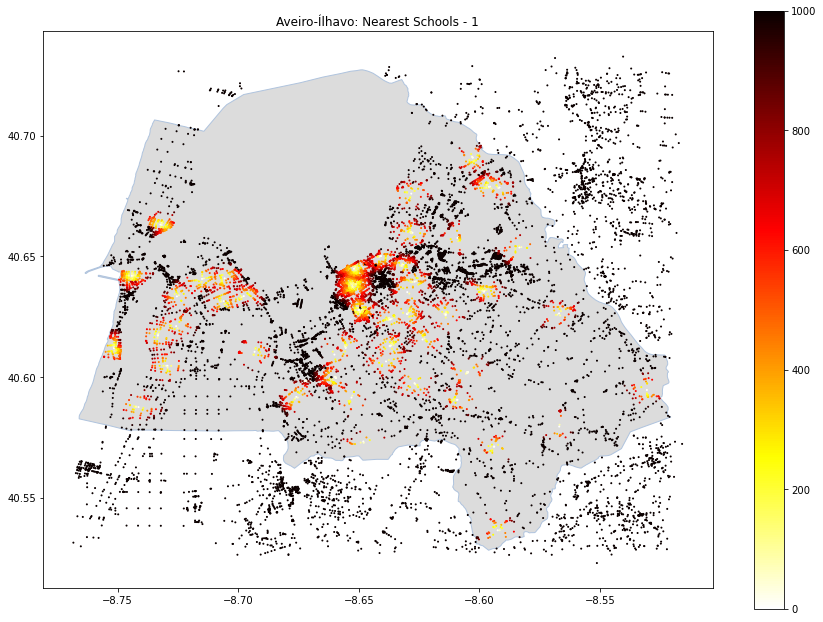

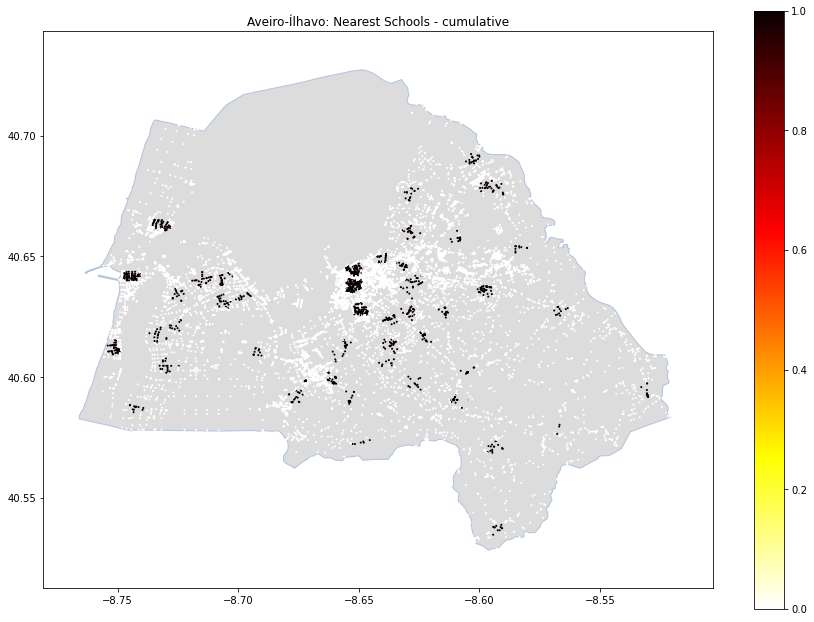

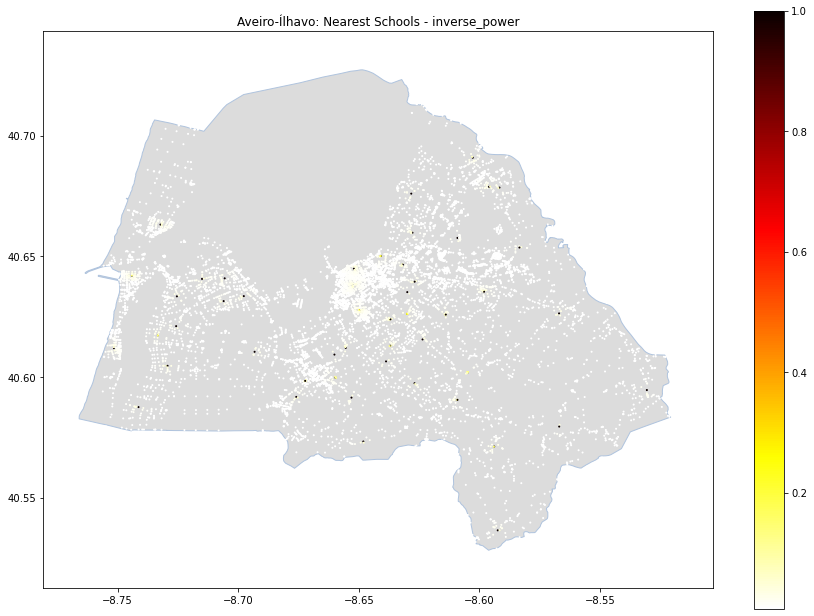

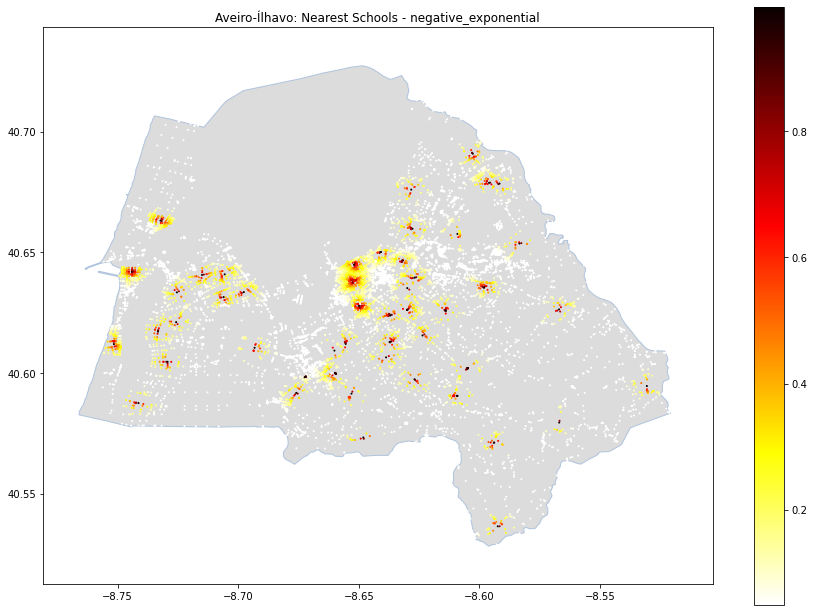

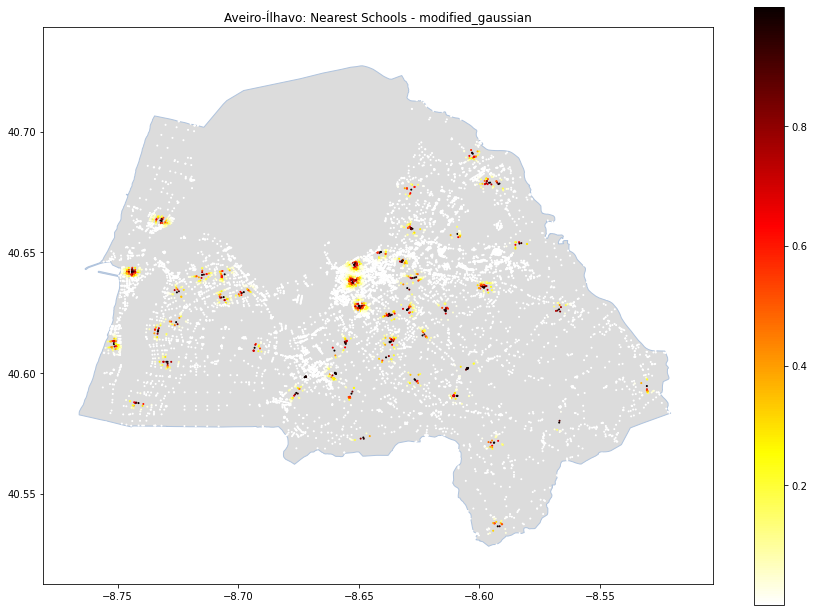

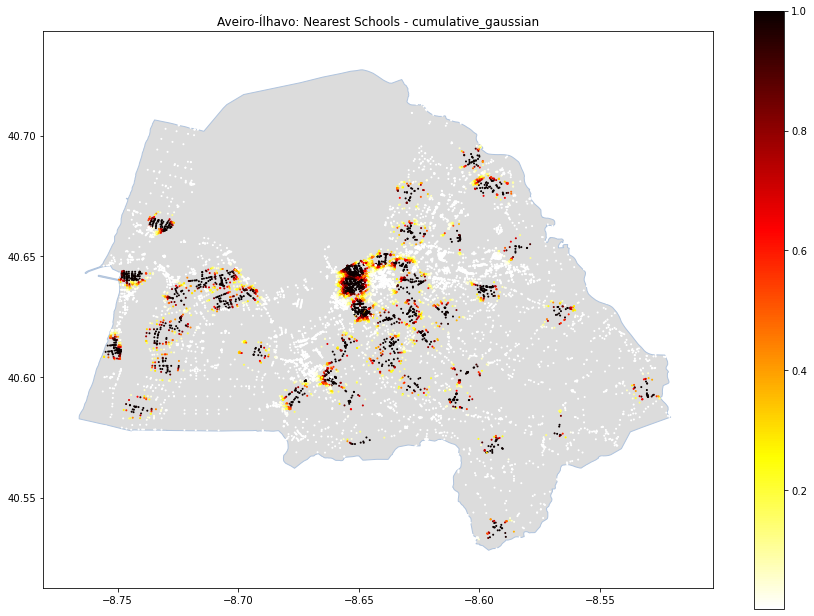

In [16]:
plot_functions(impedance, 1)
plot_functions(impedance, 'cumulative')
plot_functions(impedance, 'inverse_power')
plot_functions(impedance, 'negative_exponential')
plot_functions(impedance, 'modified_gaussian')
plot_functions(impedance, 'cumulative_gaussian')

In [17]:
# Select Accessibility Data based on region
aveiro_accessibility = select_accessibility('AVEIRO')
ilhavo_accessibility = select_accessibility('ÍLHAVO')
aveiro_ilhavo_accessibility = pd.concat([aveiro_accessibility,ilhavo_accessibility])

In [18]:
# Merge Polygons with IQ and AccessN1 data
aveiro_ilhavo_polygon = aveiro_ilhavo_polygon.merge(aveiro_ilhavo_accessibility[['BGRI', 'IQ','accessN1']], how='left', left_on='BGRI11', right_on='BGRI')

In [19]:
# get only missing subsection points
aveiro_ilhavo_missing = aveiro_ilhavo_polygon[aveiro_ilhavo_polygon.accessN1.isna()]
aveiro_ilhavo_missing['geometry'] = aveiro_ilhavo_missing.centroid

In [20]:
# Fix missings and get IQ from raw base
aveiro_ilhavo_missing = aveiro_ilhavo_missing.drop(columns=['BGRI', 'IQ', 'accessN1'])
aveiro_ilhavo_missing = aveiro_ilhavo_missing.merge(portugal_qi, how='left', left_on='BGRI11', right_on='BGRI11')

In [21]:
# Find distance lenght for the missing subsections
aveiro_ilhavo_missing = get_point_X_Y(aveiro_ilhavo_missing)
centroid_nodes = network.get_node_ids(aveiro_ilhavo_missing.nodeX, aveiro_ilhavo_missing.nodeY).values


In [22]:
# Get the distances from the accessibility dataframe (using nearest nodes)
missing_distances = []
for missing in centroid_nodes:
    distance = accessibility[accessibility.index==missing].iloc[0][1]
    missing_distances.append(distance)
aveiro_ilhavo_missing['accessN1'] = missing_distances

In [23]:
# Change index to allow distances and IQ allocation
aveiro_ilhavo_polygon.index=aveiro_ilhavo_polygon.BGRI11
aveiro_ilhavo_missing.index=aveiro_ilhavo_missing.BGRI11

# Index and allocate respective values on original dataframe
aveiro_ilhavo_polygon.loc[aveiro_ilhavo_polygon.accessN1.isna(), 'accessN1'] = aveiro_ilhavo_missing.loc[:,'accessN1']
aveiro_ilhavo_polygon.loc[aveiro_ilhavo_polygon.IQ.isna(), 'IQ'] = aveiro_ilhavo_missing.loc[:,'IQ']

<AxesSubplot:>

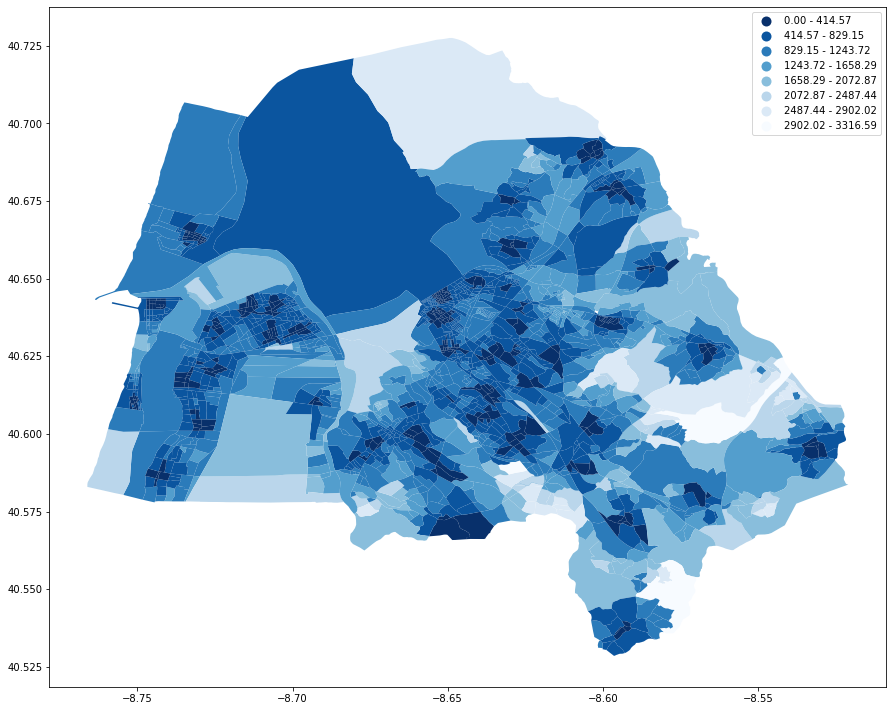

In [24]:
aveiro_ilhavo_polygon.plot(column='accessN1', cmap='Blues_r', figsize=(15,15), k=8, scheme='equal_interval', legend=True)

<AxesSubplot:>

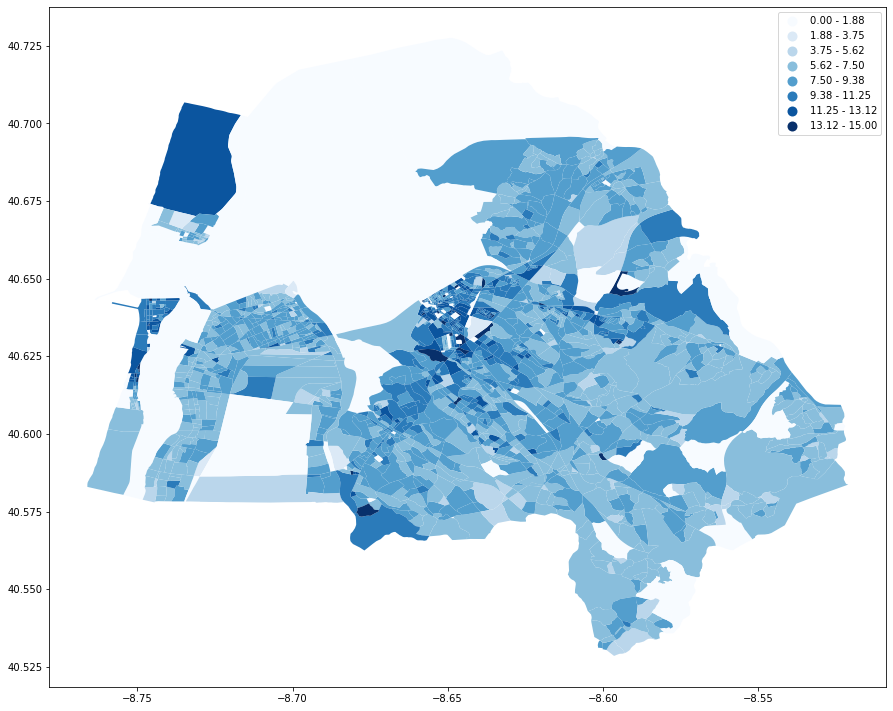

In [25]:
aveiro_ilhavo_polygon.plot(column='IQ', cmap='Blues', figsize=(15,15), k=8, scheme='equal_interval', legend=True)

In [26]:
labels = ["less than 1 year", "1 to 4 years", "4 to 6 years", "6 to 8 years", "8 to 12 years", "12 or more"]
bins = pd.IntervalIndex.from_tuples([(-1, 1), (1, 4), (4, 6),(6,8),(8,12),(12,100)])

In [27]:
bins = [-1,1,4,6,8,12,16]

In [28]:
aveiro_ilhavo_polygon['group'] = pd.cut(aveiro_ilhavo_polygon.IQ,bins,labels=labels)

<AxesSubplot:>

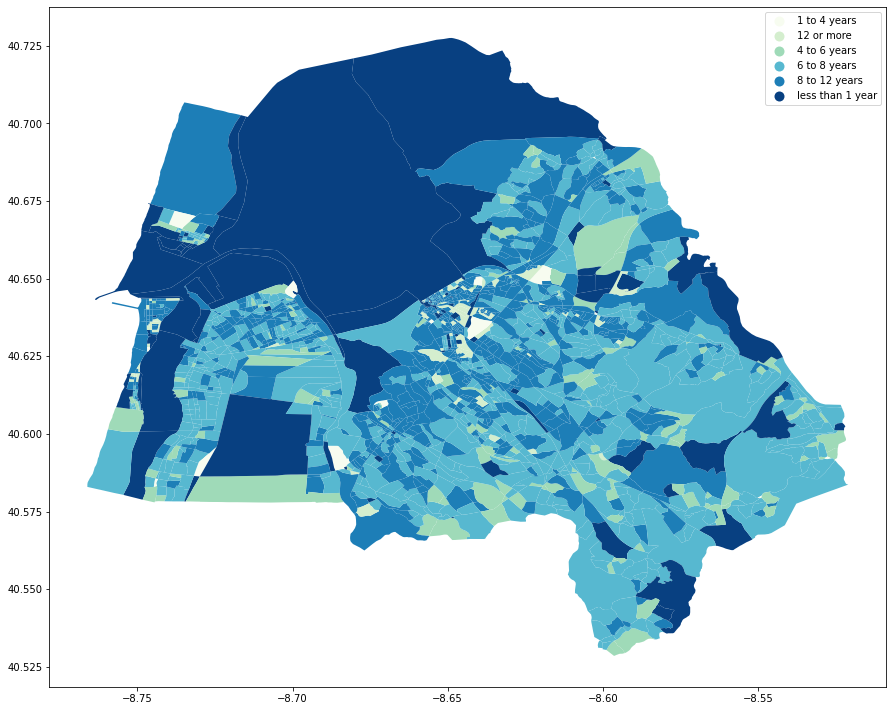

In [29]:
aveiro_ilhavo_polygon.plot(column='group', categorical=True, cmap='GnBu', figsize=(15,15), legend=True)

In [30]:
aveiro_ilhavo_polygon[['accessN1','IQ']].describe()

,accessN1,IQ
count,1920.000000,1920.000000
mean,846.399010,7.862831
std,525.883006,2.680647
min,0.000000,0.000000
25%,485.011497,6.675048
50%,740.864990,7.860233
75%,1058.268857,9.333333
max,3316.588745,15.000000


In [31]:
aveiro_ilhavo_polygon.to_excel('./data/impedanceWithIQ.xlsx')

In [32]:
bbox

[40.528483668674504, -8.766088884173485, 40.727553602062116, -8.52096487158564]

In [ ]:
# Get different amenities to include in calculation
aveiro_ilhavo_pois = pd.read_csv('./data/pois/aveiro-ilhavo.csv')

,BGRI11,IQ
0,01010100101,6.285714
1,01010100102,6.210526
2,01010100103,6.000000
3,01010100104,2.000000
4,01010100105,5.642857
...,...,...
265950,49010100119,5.714286
265951,49010100120,5.850000
265952,49010100121,7.200000
265953,49010100122,7.916667
